In [78]:
import sys
from pathlib import Path

root = Path('..').resolve() # resolve() is used to get the absolute path of the directory
sys.path.insert(0, str(root))

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

import data_utils as du
import image_utility as iu
from models import XceptionModel
from model_container import ModelContainer
import train_config as tc

In [134]:
torch_model = XceptionModel(num_classes=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, torch_model.parameters()), lr=0.001)

model = ModelContainer.load_from_checkpoint(root / 'checkpoints' / 'best-checkpoint-v5.ckpt', model=torch_model, criterion=criterion, optimizer=optimizer)
model.to(tc.device);

/home/andrea/Documents/Thesis/polar-lows-detection-forecasting-deep-learning/data/train/pos/335f14_20180114T184223_20180114T184423_mos_rgb.png
Predicted: pos. Actual: pos


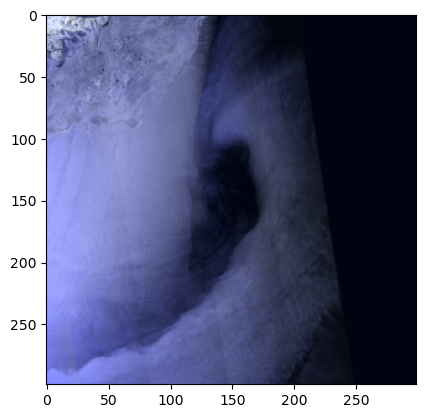

In [135]:
# image_path = du.pick_random_image(root / 'data' / 'train', 'pos')
image_path = '/home/andrea/Documents/Thesis/polar-lows-detection-forecasting-deep-learning/data/train/pos/335f14_20180114T184223_20180114T184423_mos_rgb.png'
print(image_path)
image = du.load_and_transform_image(image_path, tc.transform_prep, tc.device)

# Predict image class
model.eval()
pred = torch.argmax(model(image), dim=1).item()
print(f'Predicted: {"pos" if pred==1 else "neg"}. Actual: pos')

# Visualize the image
plt.imshow(iu.normalize_image(iu.convert_to_np_array(image)))
plt.show()

In [136]:
import iterative_training.iterative_training_utils as itu

resolution = 1
max_translations = itu.find_maximum_translations(model, image, resolution=resolution)
max_translations

{'up': 264, 'down': 240, 'left': 168, 'right': 272}

Let's first visualize the maximum translation towards the left.
This is the limit the image can be translated to before it is not recognized anymore as containing a hurricane.
The image shown below therefore represents the part of the image that was non-discriminative for the hurricane class (the model alone does not understand the positivity from this part of the image)

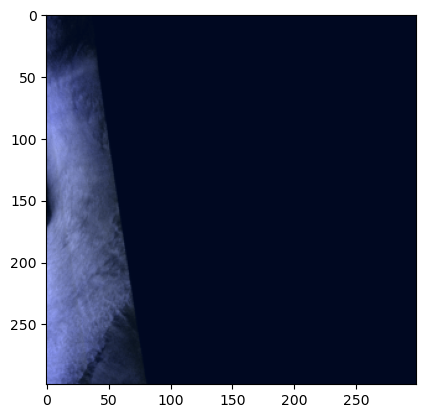

In [137]:
transl_img = iu.translate_image(image, (-max_translations['left'], 0), tc.mean, tc.std)
# plt.imshow(iu.normalize_image(iu.convert_to_np_array(transl_img)))
plt.imshow(iu.normalize_image(iu.convert_to_np_array(transl_img)))
plt.show()

We can see that the translated image is still recognized as a hurricane.

In [138]:
pred = torch.argmax(model(transl_img), dim=1).item()
print(f'Predicted: {"pos" if pred==1 else "neg"}. Actual: pos')

Predicted: pos. Actual: pos


But, if we translate the image further (by *resolution*), the image is not recognized as a hurricane anymore

In [139]:
pred = torch.argmax(model(iu.translate_image(image, (-max_translations['left']-resolution, 0), tc.mean, tc.std)), dim=1).item()
print(f'Predicted: {"pos" if pred==1 else "neg"}. Actual: pos')

Predicted: neg. Actual: pos


We can now use this translation limit to set an initial boundary of the hurricane.
A vertical line can be drawn where the recognition limit is found.

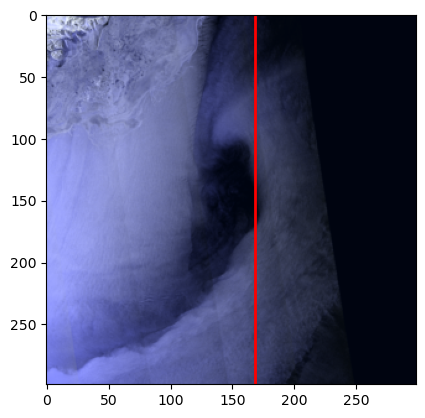

In [140]:
plt.imshow(iu.normalize_image(iu.convert_to_np_array(image)))
plt.axvline(x=max_translations['left'], color='red', linewidth=2)
plt.show()

The same thing can be done using the maximum value for the translation towards the right.

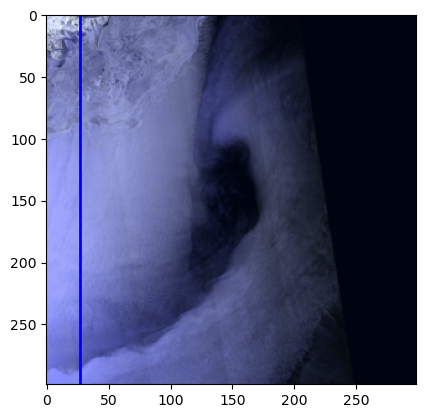

In [141]:
plt.imshow(iu.normalize_image(iu.convert_to_np_array(image)))
plt.axvline(x=299-max_translations['right'], color='blue', linewidth=2)
plt.show()

If we plot them together:

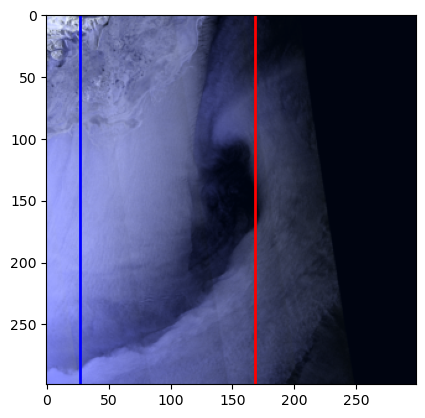

In [142]:
plt.imshow(iu.normalize_image(iu.convert_to_np_array(image)))
plt.axvline(x=max_translations['left'], color='red', linewidth=2)
plt.axvline(x=299-max_translations['right'], color='blue', linewidth=2)
plt.show()

We can also apply the same procedure towards the up

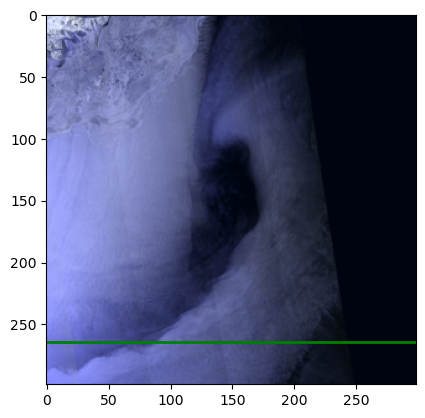

In [143]:
plt.imshow(iu.normalize_image(iu.convert_to_np_array(image)))
plt.axhline(y=max_translations['up'], color='green', linewidth=2)
plt.show()

In [144]:
pred = torch.argmax(model(iu.translate_image(image, (0, -max_translations['up']), tc.mean, tc.std)), dim=1).item()
print(f'Predicted: {"pos" if pred==1 else "neg"}. Actual: pos')

Predicted: pos. Actual: pos


In [145]:
pred = torch.argmax(model(iu.translate_image(image, (0, -max_translations['up']-resolution), tc.mean, tc.std)), dim=1).item()
print(f'Predicted: {"pos" if pred==1 else "neg"}. Actual: pos')

Predicted: neg. Actual: pos


For the down direction:

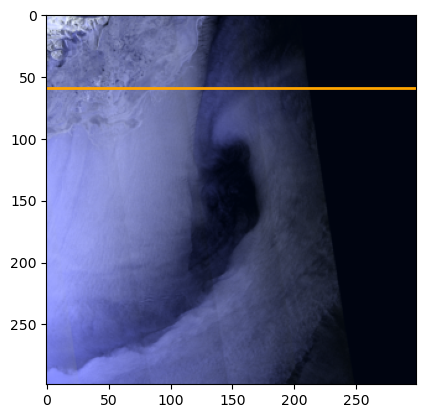

In [146]:
plt.imshow(iu.normalize_image(iu.convert_to_np_array(image)))
plt.axhline(y=299-max_translations['down'], color='orange', linewidth=2)
plt.show()

In [147]:
pred = torch.argmax(model(iu.translate_image(image, (0, max_translations['down']), tc.mean, tc.std)), dim=1).item()
print(f'Predicted: {"pos" if pred==1 else "neg"}. Actual: pos')

Predicted: pos. Actual: pos


In [148]:
pred = torch.argmax(model(iu.translate_image(image, (0, max_translations['down']+resolution), tc.mean, tc.std)), dim=1).item()
print(f'Predicted: {"pos" if pred==1 else "neg"}. Actual: pos')

Predicted: neg. Actual: pos


Putting them all together:

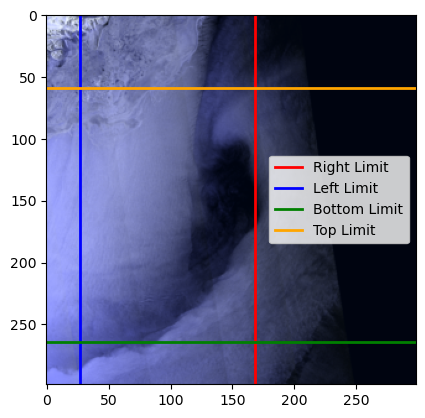

In [149]:
plt.imshow(iu.normalize_image(iu.convert_to_np_array(image)))
plt.axvline(x=max_translations['left'], color='red', linewidth=2, label='Right Limit')
plt.axvline(x=299-max_translations['right'], color='blue', linewidth=2, label='Left Limit')
plt.axhline(y=max_translations['up'], color='green', linewidth=2, label='Bottom Limit')
plt.axhline(y=299-max_translations['down'], color='orange', linewidth=2, label='Top Limit')

plt.legend()

plt.show()

We can also test this using an image with a hurricane in a corner

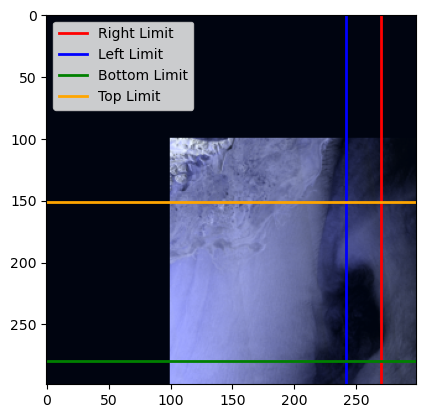

In [150]:
translated_image = iu.translate_image(image, (100, 100), tc.mean, tc.std)
max_tr = itu.find_maximum_translations(model, translated_image, resolution=resolution)

plt.imshow(iu.normalize_image(iu.convert_to_np_array(translated_image)))
plt.axvline(x=max_tr['left'], color='red', linewidth=2, label='Right Limit')
plt.axvline(x=299-max_tr['right'], color='blue', linewidth=2, label='Left Limit')
plt.axhline(y=max_tr['up'], color='green', linewidth=2, label='Bottom Limit')
plt.axhline(y=299-max_tr['down'], color='orange', linewidth=2, label='Top Limit')

plt.legend()

plt.show()

We can draw a bounding box given these values of maximum translations

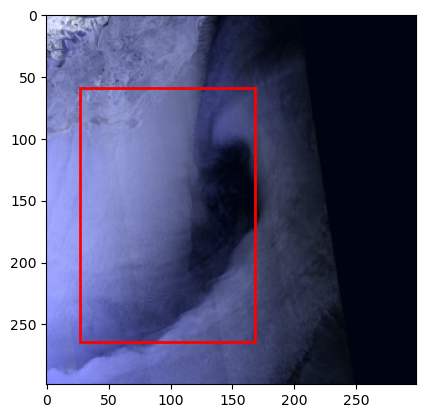

In [151]:
bb = itu.bounding_box_from_max_translations(max_translations)
itu.plot_bounding_box(image, bb)

We can also retrieve the area of the bounding box given by the maximum translation values. Note that if the right limit is to the left of the left limit, or the up limit is below the down limit, the area returned is 0.

In [152]:
print(itu.area_from_max_translations(max_translations))

28905
